<a href="https://colab.research.google.com/github/kboroz/DeepFinance/blob/main/DeepFinance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Libraries laden
import numpy as np
from math import log, sqrt, exp
from scipy import stats
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import datetime as dt
import seaborn as sns
import warnings

In [2]:
def generate_paths(spot, drift, sigma, years, points, sims):
    
    # create numpy PCG PRNG
    rng = np.random.default_rng(seed=123)
    # create random numbers
    dW = rng.normal(size=(sims, points * years))
    # get our scaled random deviations
    scaled_dW = dW * (sigma / points**0.5)
    # add on the drift
    daily_devs = (drift / points) + scaled_dW
    # cumsum them as log returns additive
    cum_rets = np.cumsum(daily_devs, axis=1)
    # add in 0 at start for starting price
    cum_rets = np.insert(cum_rets, 0, 0, axis=1)
    # create price series
    pxs = spot * np.exp(cum_rets)
    
    return daily_devs, pxs


In [3]:
# determine our process parameters
px = 100
sigma = 0.16
risk_free = 0.05
divs = 0.00

# determine our sim settings
# i.e. we want 10,000 sets of 252 random numbers
sims = 10000
points = 252
years = 1

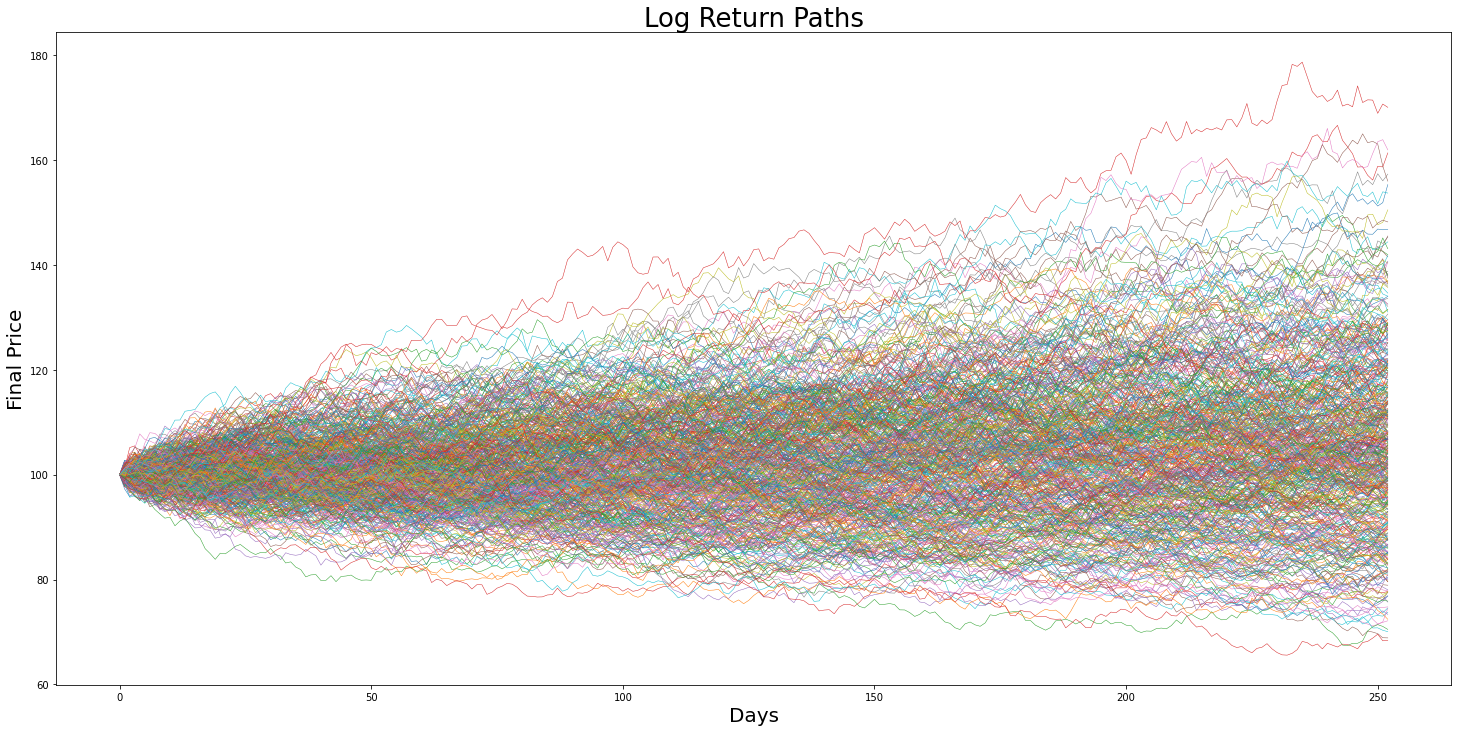

In [4]:
# churn out sims
rets, pxs = generate_paths(px, risk_free - divs, sigma, years, points, sims)

# plot them
fig, ax = plt.subplots(figsize=(25,12))

for p in pxs[:500]:
    ax.plot([z for z in range(0, points*years+1)], p, linewidth=0.5)
    
ax.set_title('Log Return Paths', fontsize=26)
ax.set_xlabel('Days', fontsize=20)
ax.set_ylabel('Final Price', fontsize=20);

In [5]:
pxs

array([[100.        ,  99.02765876,  98.68082621, ..., 130.60880367,
        129.74542308, 126.20460757],
       [100.        , 100.92597921, 101.72623822, ...,  88.0725886 ,
         88.74776407,  89.63744016],
       [100.        , 101.60395512, 102.60157724, ..., 109.23746187,
        111.41338254, 112.36693242],
       ...,
       [100.        , 100.09599278,  99.37630675, ..., 102.52000426,
        102.4920025 , 102.87021133],
       [100.        ,  99.70517543, 101.3901457 , ..., 125.26519112,
        125.46560766, 125.53026646],
       [100.        , 101.57611786, 101.11773247, ...,  89.57364338,
         89.13797996,  89.83573492]])

In [6]:
# Function that equals R's expand_grid
import itertools
def expand_grid(data_dict):
    rows = itertools.product(*data_dict.values())
    return pd.DataFrame.from_records(rows, columns=data_dict.keys())

In [7]:
# Generate sznthetic data
synthetic_data = expand_grid({
    'stock_price': np.arange(40, 61, step = 3),
    'strike_price':np.arange(20, 90, step = 3),
    'maturity': np.arange(3/12, 2, step = 1/12),
    'risk_free_rate':np.arange(0.01, 0.06, step = 0.02),
    'sigma': np.arange(0.1, 0.9, step = 0.2)
}
)

In [8]:
synthetic_data

,stock_price,strike_price,maturity,risk_free_rate,sigma
0,40,20,0.250000,0.01,0.1
1,40,20,0.250000,0.01,0.3
2,40,20,0.250000,0.01,0.5
3,40,20,0.250000,0.01,0.7
4,40,20,0.250000,0.03,0.1
...,...,...,...,...,...
42331,58,89,1.916667,0.03,0.7
42332,58,89,1.916667,0.05,0.1
42333,58,89,1.916667,0.05,0.3
42334,58,89,1.916667,0.05,0.5


In [9]:
# Black-Scholes Modell zur Berechnung der IV
def bs_option_value(S0, K, T, r, sigma):
    'Function to calculate the value of a call option based on the Black-Scholes formula'
    'arguments:'
    'S0: inital stock price'
    'K: strike price'
    'T: maturity'
    'r: risk free rate (constant)'
    'sigma: volatility'
    'returns: option value'
    #calculate d1 and d2
    d1 = ((np.log(S0 / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T)))
    d2 = ((np.log(S0 / K) + (r - 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T)))
    option_value = S0 * stats.norm.cdf(d1, 0.0, 1.0) - K * np.exp(-r * T) * stats.norm.cdf(d2, 0.0, 1.0)
    return option_value

In [12]:


# Testing the function
bs_option_value(100,50,0.1,1,1)



54.799262698334644

In [13]:


# calculate option vega
def option_vega(S0, K, T, r, sigma):
    'takes the same arguments as the function above'
    'returns option vega'
    d1 = ((np.log(S0 / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * sqrt(T)))
    vega = S0 * stats.norm.cdf(d1, 0.0, 1.0) * np.sqrt(T)
    return vega



In [14]:


# Testing the function
option_vega(100,50,0.25,1,1)



49.18361429448572

In [15]:


# calculate implied volatility
def implied_volatility(S0, K, T, C, r, sigma):
    'calculates the implied volatility'
    'S0: inital stock price'
    'K: strike price'
    'T: maturity'
    'C0: '
    'sigma_est:'
    'it: number of iterations'
    'returns implied volatility'
    d1 = (np.log(S0 / K) + (r - 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = (np.log(S0 / K) + (r - 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    
    fx = S0 * stats.norm.cdf(d1, 0.0, 1.0) - K * np.exp(-r * T) * stats.norm.cdf(d2, 0.0, 1.0) - C
    
    vega = (1 / np.sqrt(2 * np.pi)) * S0 * np.sqrt(T) * np.exp(-(stats.norm.cdf(d1, 0.0, 1.0) ** 2) * 0.5)
    # Warum hier andere Formal fuer vega?
    
    tolerance = 0.000001
    x0 = sigma
    xnew  = x0
    xold = x0 - 1
        
    while abs(xnew - xold) > tolerance:
    
        xold = xnew
        xnew = (xnew - fx - C) / vega
        
        return abs(xnew)
# Quelle fuer vega und iv : https://aaronschlegel.me/implied-volatility-functions-python.html



In [16]:


# Testing the function
implied_volatility(100,50,0.5,50,1,1)



3.3391194815314065

In [17]:


synthetic_data['black_scholes'] = bs_option_value(synthetic_data['stock_price'], synthetic_data['strike_price'],
                                               synthetic_data['maturity'], synthetic_data['risk_free_rate'],
                                               synthetic_data['sigma'])



In [18]:


# Add some random noise to the real prices to create the option prices
synthetic_data["option_price"] = synthetic_data["black_scholes"] + np.random.normal(0, 0.1)



In [19]:


synthetic_data.head()



,stock_price,strike_price,maturity,risk_free_rate,sigma,black_scholes,option_price
0,40,20,0.25,0.01,0.1,20.049938,20.067913
1,40,20,0.25,0.01,0.3,20.049939,20.067915
2,40,20,0.25,0.01,0.5,20.055598,20.073573
3,40,20,0.25,0.01,0.7,20.135689,20.153664
4,40,20,0.25,0.03,0.1,20.149439,20.167414


In [20]:
synthetic_data.tail()

,stock_price,strike_price,maturity,risk_free_rate,sigma,black_scholes,option_price
42331,58,89,1.916667,0.03,0.7,15.143754,15.161729
42332,58,89,1.916667,0.05,0.1,0.025690,0.043665
42333,58,89,1.916667,0.05,0.3,3.374656,3.392632
42334,58,89,1.916667,0.05,0.5,9.384355,9.402331
42335,58,89,1.916667,0.05,0.7,15.770706,15.788682


In [21]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(synthetic_data.drop(["black_scholes"], axis = 1), test_size = 0.10,
                                                   random_state = 42)

In [22]:
train.head()

,stock_price,strike_price,maturity,risk_free_rate,sigma,option_price
12006,43,89,1.333333,0.03,0.5,1.964737
447,40,23,1.583333,0.01,0.7,21.308824
19370,49,32,1.750000,0.01,0.5,21.354044
20397,49,44,1.833333,0.05,0.3,12.450250
21373,49,56,1.666667,0.01,0.3,5.327079


In [23]:
train.tail()

,stock_price,strike_price,maturity,risk_free_rate,sigma,option_price
6265,43,20,1.750000,0.01,0.3,23.468624
11284,43,80,1.583333,0.03,0.1,0.017979
38158,58,41,0.916667,0.05,0.5,21.455755
860,40,29,0.916667,0.05,0.1,12.317188
15795,46,62,1.416667,0.01,0.7,10.689663


In [24]:
test.head()

,stock_price,strike_price,maturity,risk_free_rate,sigma,option_price
19766,49,38,1.000000,0.01,0.5,15.391724
6810,43,29,0.250000,0.03,0.5,14.435227
22451,49,71,0.333333,0.05,0.7,2.466067
24960,52,29,0.333333,0.01,0.1,23.114481
20573,49,47,1.333333,0.03,0.3,8.590377


In [25]:
test.tail()

,stock_price,strike_price,maturity,risk_free_rate,sigma,option_price
8528,43,47,1.666667,0.05,0.1,2.118359
10873,43,77,0.500000,0.01,0.3,0.029894
18245,49,20,0.916667,0.03,0.3,29.562019
34734,55,71,1.666667,0.03,0.5,10.005539
37073,58,29,0.416667,0.03,0.3,29.378476


In [ ]:


# Daten standardisieren
#from sklearn.preprocessing import StandardScaler
#scaler = StandardScaler()



In [ ]:
#scaler

In [ ]:


#def standardize(train, test, cols):
    
    # Pruefen, ob korrekt spaltenweise standardisiert wurde - > passt
 #   cols = cols
    
  #  scaler = StandardScaler().fit(train[cols])
   # train_std=pd.DataFrame(scaler.transform(train[cols]), columns = cols)

    #test_std=pd.DataFrame(scaler.transform(test[cols]), columns = cols)
    #return train_std, test_std



In [ ]:
#train_std.head()

In [ ]:


#columns = ["stock_price", 'strike_price', 'maturity', 'risk_free_rate', 'sigma', 'option_price']
#train_std, test_std = standardize(train, test, columns)



In [ ]:


# All variables now have 0 mean and std.dev 1
#train_std.describe()



In [26]:
# Dataframes with Xs and ys
x_train = train.drop(['option_price'], axis = 1)
x_test = test.drop(['option_price'], axis = 1)
y_train = train['option_price']
y_test = test['option_price']

In [27]:
x_train

,stock_price,strike_price,maturity,risk_free_rate,sigma
12006,43,89,1.333333,0.03,0.5
447,40,23,1.583333,0.01,0.7
19370,49,32,1.750000,0.01,0.5
20397,49,44,1.833333,0.05,0.3
21373,49,56,1.666667,0.01,0.3
...,...,...,...,...,...
6265,43,20,1.750000,0.01,0.3
11284,43,80,1.583333,0.03,0.1
38158,58,41,0.916667,0.05,0.5
860,40,29,0.916667,0.05,0.1


In [28]:
# Netz bauen, noch kein finetuning


model = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(input_shape = (5,)), # Anzahl Features
    tf.keras.layers.Dense(units = 1000, activation = 'elu'),
    tf.keras.layers.Dropout(rate = 0.25),
    tf.keras.layers.Dense(units = 800, activation = 'elu'),
    tf.keras.layers.Dropout(rate = 0.25),
    tf.keras.layers.Dense(units = 600, activation = 'elu'),
    tf.keras.layers.Dropout(rate = 0.25),
    tf.keras.layers.Dense(units = 64, activation = 'elu'),
    tf.keras.layers.Dropout(rate = 0.25),
    tf.keras.layers.Dense(units = 1, activation = 'elu')
])
model.compile(loss='mse',optimizer='adam')



In [29]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1000)              6000      
                                                                 
 dropout (Dropout)           (None, 1000)              0         
                                                                 
 dense_1 (Dense)             (None, 800)               800800    
                                                                 
 dropout_1 (Dropout)         (None, 800)               0         
                                                                 
 dense_2 (Dense)             (None, 600)               480600    
                                                                 
 dropout_2 (Dropout)         (None, 600)               0         
                                                                 
 dense_3 (Dense)             (None, 64)                3

In [30]:
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
callback = EarlyStopping(monitor='loss', patience=4) # This callback will stop the training when there is no improvement in the validation loss for three consecutive epochs. model = tf.keras.models.Sequential([tf.keras.layers.Dense(10)]) 
#model.compile(tf.keras.optimizers.SGD(), loss='mse') 
#history = model.fit(np.arange(100).reshape(5, 20), np.zeros(5), 
                  #  epochs=10, batch_size=1, callbacks=[callback], 
                   # verbose=0) 
#len(history.history['loss'])  # Only 4 epochs are run.

#tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
#                                min_delta=0, 
#                                patience=0, 
#                                verbose=0, 
#                                mode='auto', 
#                                baseline=None, 
#                                restore_best_weights=False)

# https://blog.paperspace.com/tensorflow-callbacks/

In [31]:
history = model.fit(x_train, y_train, validation_split=0.2, batch_size = 1000, epochs = 100,callbacks=[callback])
# missing callback

Epoch 1/100
31/31 [==============================] - 4s 13ms/step - loss: 65.6471 - val_loss: 13.7972
Epoch 2/100
31/31 [==============================] - 0s 7ms/step - loss: 20.4201 - val_loss: 13.5835
Epoch 3/100
31/31 [==============================] - 0s 6ms/step - loss: 18.6895 - val_loss: 13.0581
Epoch 4/100
31/31 [==============================] - 0s 6ms/step - loss: 17.5593 - val_loss: 12.2788
Epoch 5/100
31/31 [==============================] - 0s 6ms/step - loss: 16.7531 - val_loss: 11.6470
Epoch 6/100
31/31 [==============================] - 0s 6ms/step - loss: 15.0123 - val_loss: 10.2571
Epoch 7/100
31/31 [==============================] - 0s 6ms/step - loss: 12.8284 - val_loss: 4.8025
Epoch 8/100
31/31 [==============================] - 0s 6ms/step - loss: 10.1485 - val_loss: 5.2859
Epoch 9/100
31/31 [==============================] - 0s 6ms/step - loss: 7.7488 - val_loss: 2.3898
Epoch 10/100
31/31 [==============================] - 0s 6ms/step - loss: 6.6340 - val_loss: 2

In [32]:
y_hat = model.predict(x_test)

In [33]:
y_hat

array([[14.139048 ],
       [14.815607 ],
       [ 2.8088138],
       ...,
       [29.294844 ],
       [ 7.989522 ],
       [28.546755 ]], dtype=float32)

In [34]:
y_hat.size

4234

In [35]:
y_hat = np.squeeze(y_hat)

In [36]:
y_hat

array([14.139048 , 14.815607 ,  2.8088138, ..., 29.294844 ,  7.989522 ,
       28.546755 ], dtype=float32)

In [37]:
def CheckAccuracy(y,pull):
    stats = dict()
    
    stats['diff'] = y - y_hat
    
    stats['mse'] = np.mean(stats['diff']**2)
    print("Mean Squared Error:      ", stats['mse'])
    
    stats['rmse'] = np.sqrt(stats['mse'])
    print("Root Mean Squared Error: ", stats['rmse'])
    
    stats['mae'] = np.mean(abs(stats['diff']))
    print("Mean Absolute Error:     ", stats['mae'])
    
    stats['mpe'] = np.sqrt(stats['mse'])/np.mean(y)
    print("Mean Percent Error:      ", stats['mpe'])
    
    #plots
    plt.rcParams['agg.path.chunksize'] = 1000
    plt.figure(figsize=(10,10))
    plt.scatter(y, y_hat,color='black',linewidth=0.3,alpha=0.4, s=0.5)
    plt.xlabel('Actual Price',fontsize=20,fontname='Times New Roman')
    plt.ylabel('Predicted Price',fontsize=20,fontname='Times New Roman') 
    plt.show()
    
    plt.figure(figsize=(10,10))
    plt.hist(stats['diff'], bins=100,edgecolor='black',color='white')
    plt.xlabel('Diff')
    plt.ylabel('Density')
    plt.show()
    
    return stats

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


Mean Squared Error:       1.6966509167131436
Root Mean Squared Error:  1.3025555330630412
Mean Absolute Error:      1.010591644143763
Mean Percent Error:       0.12202848197150877


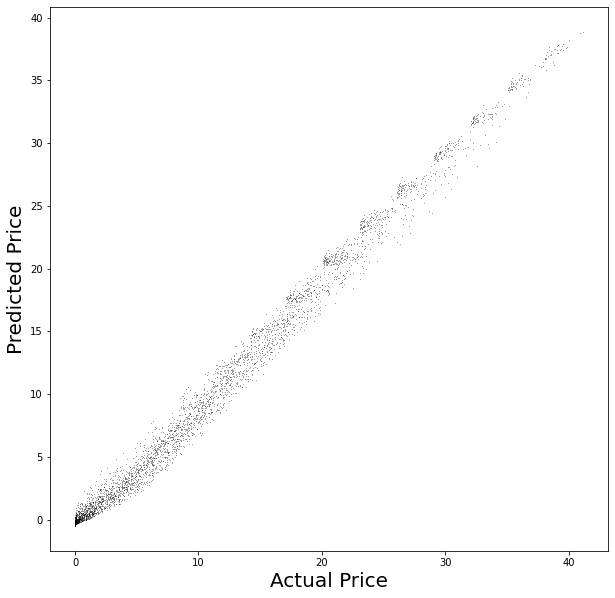

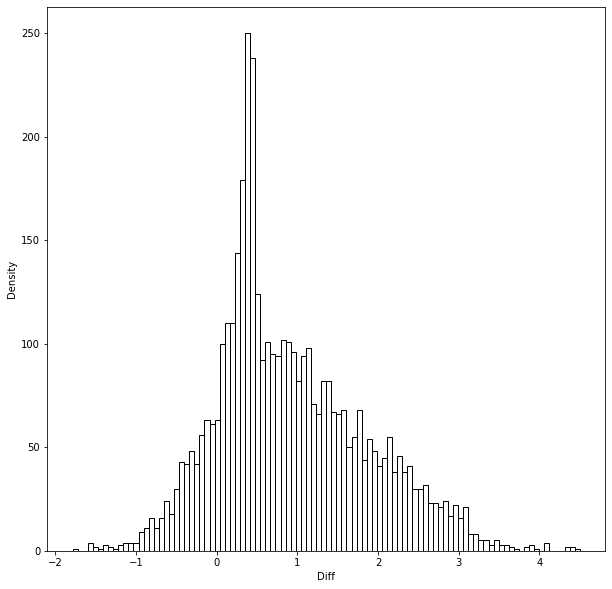

{'diff': 19766    1.252676
 6810    -0.380380
 22451   -0.342747
 24960   -0.114996
 20573    1.670406
            ...   
 8528    -0.322693
 10873    0.367334
 18245    0.267175
 34734    2.016017
 37073    0.831721
 Name: option_price, Length: 4234, dtype: float64,
 'mae': 1.010591644143763,
 'mpe': 0.12202848197150877,
 'mse': 1.6966509167131436,
 'rmse': 1.3025555330630412}

In [38]:
CheckAccuracy(y_test, y_hat)

In [39]:
def approx_func(x):
    return 0.5 + 0.5*np.sign(x)*np.sqrt(1. - np.exp(-2.*(x**2)/np.pi))

def guess_StefanicaRadoicic(option_type, strike, option_price, spot_price,
                            ir_discount, dr_discount):
    
    forward = spot_price * dr_discount / ir_discount
    ey = forward/strike #ey=exp(y)
    emy = strike/forward #emy=exp(-y)
    y = np.log(ey)
    alpha = option_price/(strike*ir_discount)
    
    if option_type==1:
        #Call
        R = 2.*alpha - ey + 1.
    else:
        #Put
        R = 2.*alpha + ey - 1.
    pi_term = 2./np.pi
    arg_exp_term = (1.-pi_term)*y
    R2 = R**2
    
    a = np.exp(arg_exp_term)
    A = (a - 1./a)**2
    b = np.exp(pi_term*y)
    B = 4.*(b + 1./b) - 2.*emy*(a + 1./a)*(ey**2 + 1. - R2)
    C = (emy**2) * (R2 - (ey - 1.)**2) * ((ey + 1.)**2 - R2)
    beta = 2.*C / (B + np.sqrt(B**2 + 4.*A*C))
    gamma = - np.pi/2.*np.log(beta)
    
    if y>=0.:
        if option_type==1: #call
            O0 = strike*ir_discount*(ey*approx_func(np.sqrt(2.*y)) - 0.5)
        else:
            O0 = strike*ir_discount*(0.5 - ey*approx_func(-np.sqrt(2.*y)))
        if option_price <= O0:
            nu = np.sqrt(gamma+y) - np.sqrt(gamma-y)
        else:
            nu = np.sqrt(gamma+y) + np.sqrt(gamma-y)
    else:
        if option_type==1: #call
            O0 = strike*ir_discount*(0.5*ey - approx_func(-np.sqrt(-2.*y)))
        else:
            O0 = strike*ir_discount*(approx_func(np.sqrt(-2.*y)) - 0.5*ey)
        if option_price <= O0:
            nu = np.sqrt(gamma-y) - np.sqrt(gamma+y)
        else:
            nu = np.sqrt(gamma+y) + np.sqrt(gamma-y)
    return nu

def Phi(x,nu):
    nu2 = nu**2
    abs_term = 2.*np.abs(x)
    return (nu2-abs_term)/(nu2+abs_term)
def N_plus(x,nu):
    return norm.cdf(x/nu + 0.5*nu)
def N_minus(x,nu):
    return np.exp(-x)*norm.cdf(x/nu - 0.5*nu)
def F(nu, x, c_star, omega):
    return c_star + N_minus(x,nu) + omega*N_plus(x,nu)
def G(nu, x, c_star, omega):
    argument = F(nu, x, c_star, omega)/(1.+omega)
    term = norm.ppf(argument)
    return term + np.sqrt(term**2 + 2.*np.abs(x))
    
def SOR_TS(option_type, strike, discount_ir, discount_dr, option_price, 
                     spot_price, guess, omega, accuracy, max_iterations=20):
    
    assert (option_price >= 0.),'Price must be positive.'
    
    forward = spot_price * discount_dr / discount_ir
    x = np.log(forward/strike)
    
    if option_type==1:  #call
        c = option_price/(spot_price*discount_dr)
    else:   #put
        c = option_price/(spot_price*discount_dr) + 1. - strike/forward
    
    if x > 0.:
        # formula in-out duality
        c = c*forward/strike + 1. - forward/strike
        assert (c >= 0.),'Normalized price must be positive.'
        x = -x
    
    if not guess:
        guess = guess_StefanicaRadoicic(option_type, strike, option_price, 
                                       spot_price, discount_ir, discount_dr)
    assert (guess >= 0.),'Initial guess must be positive.'
    
    nIter = 0
    nu_k = nu_kp1 = guess
    difference = 1.
    while (np.abs(difference)>accuracy and nIter<max_iterations):
        nu_k = nu_kp1
        alpha_k = (1.+omega)/(1.+Phi(x,nu_k))
        nu_kp1 = alpha_k*G(nu_k, x, c, omega) + (1.-alpha_k)*nu_k
        difference = nu_kp1 - nu_k
        nIter +=1
    return nu_kp1